# Урок 5. Сегментация изображений

## Домашнее задание

1. Необходимо подготовить датасет https://www.kaggle.com/olekslu/makeup-lips-segmentation-28k-samples для обучения модели на сегментацию губ

2. Обучить модель на выбор из segmentation_models_pytorch

У кого нет возможности работать через каггл (нет верификации), то можете данные взять по ссылке: https://disk.yandex.ru/d/nWMoBVgvWYcI7g

### Подключение библиотек

In [2]:
! pip install segmentation-models-pytorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 88 kB 4.1 MB/s 
     |████████████████████████████████| 376 kB 14.9 MB/s 
     |████████████████████████████████| 58 kB 6.0 MB/s 
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.6.3-py3-none-any.whl size=12421 sha256=e9e3f0333ec132c6d19177a684969790d139251df43b1b1ad8ba655ce67f2289
  Stored in directory: /root/.cache/pip/wheels/90/6b/0c/f0ad36d00310e65390b0d4c9218ae6250ac579c92540c9097a
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60965 sha256=afcbc46e4f051491cb6a26a240a6e83e879f3a45504fd632463a3bb3be48cfe7
  Stored in directory: /root/.cache/pip/wheels/ed/27/e8/9543d42de2740d3544db96aefef63bda3f2c1761b3334f4873
Successfully built efficientnet-pytorch pretrainedmodels


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam


from PIL import Image
import cv2

from sklearn.model_selection import train_test_split

from segmentation_models_pytorch import FPN
from segmentation_models_pytorch.encoders import get_preprocessing_fn
from segmentation_models_pytorch.utils.train import TrainEpoch, ValidEpoch
from segmentation_models_pytorch.utils.losses import DiceLoss
from segmentation_models_pytorch.utils.metrics import IoU

import os

import warnings
warnings.filterwarnings('ignore')

In [4]:
# проверка устройств
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu:0')
print(device)

cuda:0


In [5]:
# пути к файлам
CSV_PATH = r'/content/drive/MyDrive/set-lipstick-original/list.csv'
MASK_PATH = r'/content/drive/MyDrive/set-lipstick-original/mask'
PICTURE_PATH = r'/content/drive/MyDrive/set-lipstick-original/720p'

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Загрузка и подготовка данных

In [10]:
# Загрузим список картинок и масок
files = pd.read_csv(CSV_PATH)
files.head()

,filename,width,height,class,xmin,ymin,xmax,ymax,mask
0,image00000001.jpg,1280,720,Lips,661,394,776,444,mask00000001.png
1,image00000002.jpg,1280,720,Lips,557,336,682,392,mask00000002.png
2,image00000003.jpg,1280,720,Lips,553,369,684,427,mask00000003.png
3,image00000004.jpg,1280,720,Lips,555,351,681,408,mask00000004.png
4,image00000005.jpg,1280,720,Lips,555,351,680,407,mask00000005.png


In [ ]:
files = files.loc[files['filename'].isin(os.listdir(PICTURE_PATH))]
files = files.loc[files['mask'].isin(os.listdir(MASK_PATH))]
files.reset_index(inplace=True, drop=True)

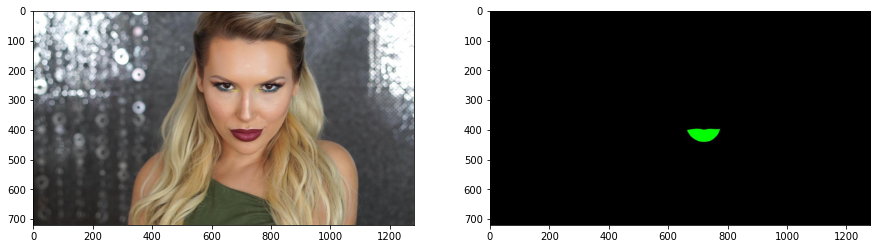

In [14]:
# отобразим одну картинку и маску
fig, ax = plt.subplots(1, 2, figsize=(15, 7))
img_picture = plt.imread(f'{PICTURE_PATH}/{pd.Series(files["filename"])[0]}')
img_mask = plt.imread(f'{MASK_PATH}/{pd.Series(files["mask"])[0]}')
ax[0].imshow(img_picture)
ax[1].imshow(img_mask)
plt.show()

In [15]:
class ImageDataset(Dataset):
    def __init__(self, data, preprocessing=None):
        self.data = data
        self.image_arr = self.data.iloc[:, 0]
        self.mask_arr = self.data.iloc[:, 1]
        self.data_len = len(self.data.index)
        self.preprocessing = preprocessing


    def __getitem__(self, index):
        pic = Image.open(f'{PICTURE_PATH}/{self.image_arr[index]}')
        pic = pic.resize((256, 256))
        pic = np.asarray(pic).astype('float')

        if self.preprocessing:
            pic = self.preprocessing(pic)
            pic = torch.as_tensor(pic)
        else:
            pic = torch.as_tensor(pic) / 255.0
        pic = pic.permute(2,0,1)

        mask = Image.open(f'{MASK_PATH}/{self.mask_arr[index]}')
        mask = mask.resize((256, 256))
        mask = np.asarray(mask).astype('float')
        if self.preprocessing:
            mask = self.preprocessing(mask)
            mask = torch.as_tensor(mask)
        else:
            mask = torch.as_tensor(mask) / 255.0

        try:
            mask = mask.permute(2, 0, 1)
        except RuntimeError as err:
            print(f'{err}\nFILE: {self.mask_arr[index]}')

        return pic.float(), mask.float()

    def __len__(self):
        return self.data_len

In [17]:
# разделим данные на тренировочные и тестовые
X_train, X_test = train_test_split(files[['filename', 'mask']], test_size=0.3, random_state=42)
X_train.reset_index(inplace=True, drop=True)
X_test.reset_index(inplace=True, drop=True)

In [20]:
# обернём данные в DataLoader
train_data = ImageDataset(X_train)
test_data = ImageDataset(X_test)
train_data_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_data_loader = DataLoader(test_data, batch_size=10, shuffle=False)

torch.Size([64, 3, 256, 256]) torch.Size([64, 3, 256, 256])
tensor(0.) tensor(1.)
tensor(0.) tensor(1.)


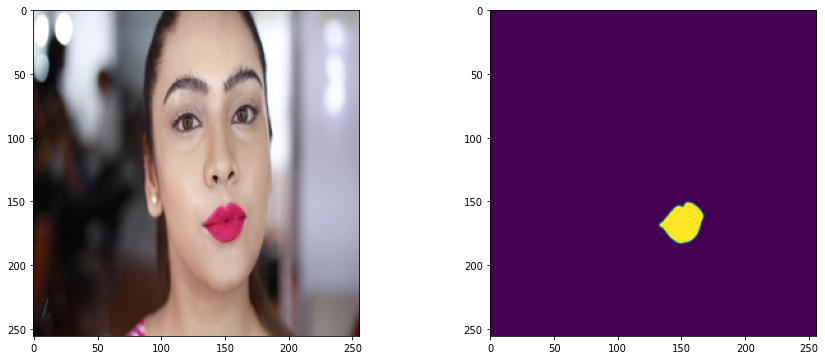

In [21]:
for img, target in train_data_loader:
    print(img.shape, target.shape)
    print(img[0].min(), img[0].max())
    print(target[0].min(), target[0].max())
    fig, ax = plt.subplots(1, 2, figsize=(15, 6))
    ax[0].imshow(img[0].permute(1, 2, 0))
    ax[1].imshow(target[0].permute(1, 2, 0)[..., 1])
    break

## Построение и обучение модели

In [22]:
model = FPN(encoder_name='resnet50',
                encoder_weights='imagenet',
                classes=1,
                activation='sigmoid'
               ).to(device=device)

preprocess_input = get_preprocessing_fn('resnet50', pretrained='imagenet')

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [23]:
criterion = DiceLoss()
metrics = [IoU(),]
optimizer = Adam(params=model.parameters(), lr=1e-3)

In [24]:
train_epoch = TrainEpoch(model=model,
                         loss=criterion,
                         metrics=metrics,
                         optimizer=optimizer,
                         device=device,
                         verbose=True)

valid_epoch = ValidEpoch(model=model,
                         loss=criterion,
                         metrics=metrics,
                         device=device,
                         verbose=True)

In [ ]:
# Обучение и сохранение модели
max_score = 0.0

for i in range(5):
    print(f'Epoch: {i + 1}')
    train_logs = train_epoch.run(train_data_loader)
    valid_logs = valid_epoch.run(test_data_loader)

    
    if max_score < valid_logs['iou_score']:
        max_score = valid_logs['iou_score']
        torch.save(model, r'/content/drive/MyDrive/set-lipstick-original/fpn_model.pth')
        print('Model saved!')    

Epoch: 1
valid: 100%|███████| 857/857 [05:38<00:00,  2.54it/s, dice_loss - 0.07508, iou_score - 0.8649]
Model saved!
Epoch: 2
valid: 100%|████████| 857/857 [04:56<00:00,  2.89it/s, dice_loss - 0.06357, iou_score - 0.884]
Model saved!
Epoch: 3
valid: 100%|███████| 857/857 [04:58<00:00,  2.87it/s, dice_loss - 0.05955, iou_score - 0.8908]
Model saved!
Epoch: 4
valid: 100%|█████████| 857/857 [05:11<00:00,  2.75it/s, dice_loss - 0.056, iou_score - 0.8964]
Model saved!
Epoch: 5
valid: 100%|███████| 857/857 [05:40<00:00,  2.52it/s, dice_loss - 0.05423, iou_score - 0.8993]
Model saved!


In [ ]:
net = torch.load('./fpn_model.pth')

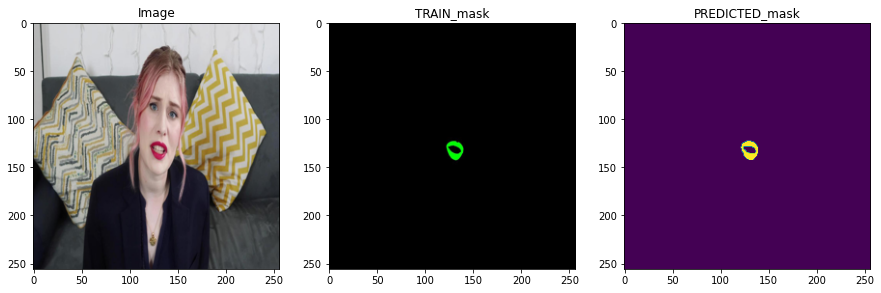

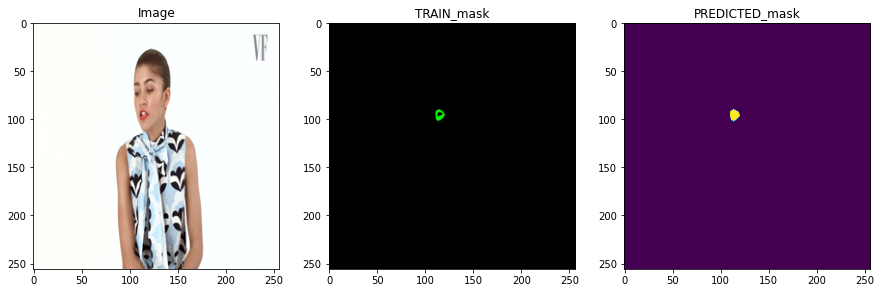

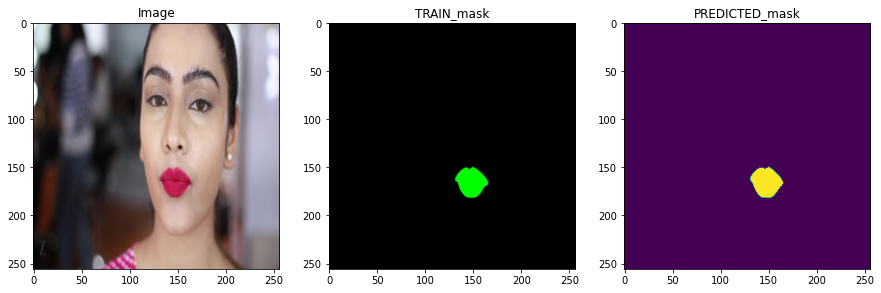

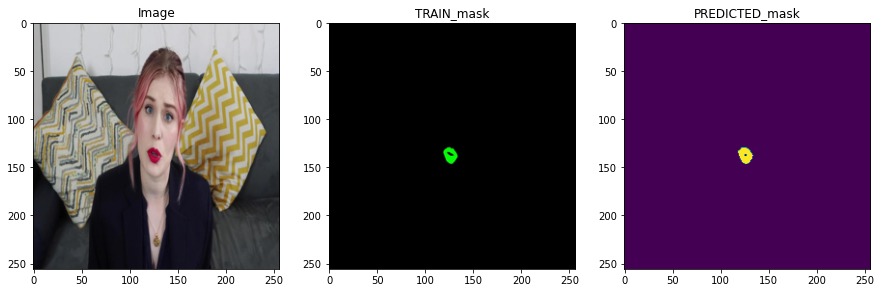

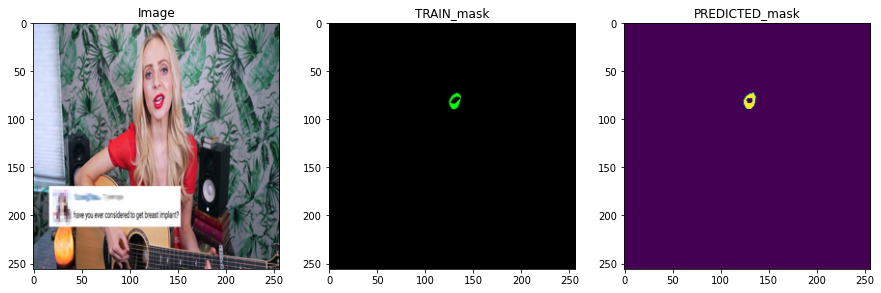

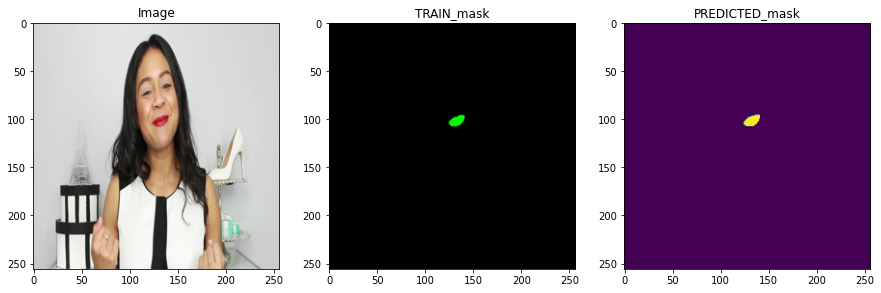

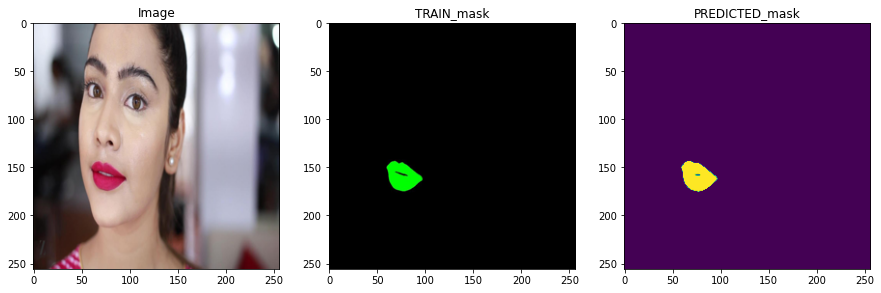

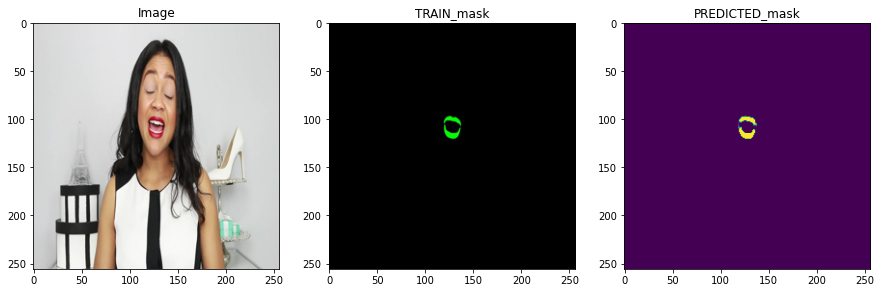

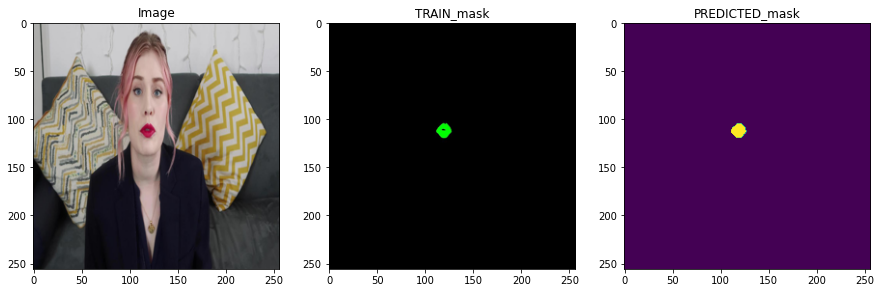

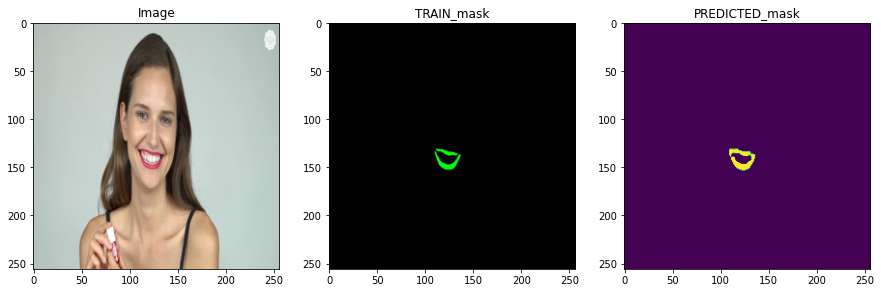

In [ ]:
for image, mask in test_data_loader:
    for i in range(image.shape[0]):
        pred = net(image[i][None].to(device))[0, ...].detach().cpu()
        fig, ax = plt.subplots(1, 3, figsize=(15, 7))
        
        ax[0].imshow(image[i].permute(1, 2, 0))
        ax[0].set_title('Image')
        
        ax[1].imshow(mask[i].permute(1, 2, 0))
        ax[1].set_title('TRAIN_mask')
        
        ax[2].imshow(pred.permute(1, 2, 0))
        ax[2].set_title('PREDICTED_mask')
        plt.show()
    break